## Map of modal choice for commuting in Madrid and the determinants of that choice. By Guillem Tobías Larrauri. 8/12/2023
#### Data and methodology:
The main data source for this map is the EDM2018 (Encuesta Domiciliaria de Movilidad 2018) done by the Consorcio de Transportes of Madrid. Complementary data comes from the Ayuntamiento de Madrid and OpenStreetMap. The EDM asks individuals from the community of Madrid how they move, these individuals are grouped into 1259 transport zones. For my analysis, I merge these zones into the 131 barrios of Madrid and exclude individuals who don't live in the city —the information is so granular that it is hard to visualize. Since I don't know in which point the individuals live within their transport zone I merge them based on the centroid of the transport zone. If the centroid of a transport zone is in a given neighborhood all observations from that transport zone belong to said neighborhood. Since transport zones are typically smaller, this rule should be good enough. For the metro and highway, I query OpenStreetMap and plot them in the final map.
With the dataset with barrio indicator I then conduct very simple data analysis, I reduce the sample to commutes—job to workplace or vice versa— and then I compute the proportion of people from that barrio that commute in different ways (walking, car, public transport) and their own reasoning —individuals are asked why they didn't use public transport— behind their choice. Individual observations are weighted in the sample, I ignore the weights for this initial analysis. The result is a collapsed dataset with an observation for each neighborhood.
For the plotting I used the explore method of GeoPandas, which is quite sophisticated, and it yields some great results—no need for CARTO—. The final result is an interactive map with two main layers "public transport use" and "It takes longer" and complementary data on metro stations and highways. Layers can be activated and deactivated with the legend. Clicking on a given neighborhood gives some extra information.
#### Facts and interpretation:
The main facts from this map are already known but it still seems like a natural place to start. People closer to the center tend to use public transport more, this is probably due to the higher density of public transport in the center and the higher likelihood that there is a good connection to where you are commuting to. As well as the fact that driving in the city center is not pleasant nor quick. Once you go beyond the absolute city center in Sol to relatively centric neighborhoods that have better roads, car use increases quickly, and it keeps increasing the further you get away from the city center. While commute distance seems to increase car use, the correlation is not that strong, and there seem to be differences between the north of the city and the south. I am sure there is an income component to these differences, and it could also be due to the fact that people from different neighborhoods commute to different places—restricting my analysis to commutes to the city center would be interesting as it would eliminate this variability. The metro is a good example of this, in general it is pretty radio-centric, if you want to get from anywhere to the city center the metro might be a good choice. But, if your commute is not to the city center that could be a driving factor in using your car and going around Madrid on the M30. 
In relation to this, I wanted to plot the highways because M30 in particular is a big segregator in terms of income (I attach a screenshot from the Atlas de La Distribución de la Renta 2021), and I wondered if it had a similar effect with modal choices. And while there seem to be some differences, it is hard to disentangle what the effect is, if any—at least visually—.
The main motive for not commuting with public transport is that it takes longer, and a second reason is that it is badly connected. It is worth mentioning that these two motives are similar, being badly connected means a much longer commute. While there seems to be some spatial correlation —people who live further away tend to say public transport would take longer— that is not the full story, there are high income neighborhoods in the center of the city where a relatively high share of people say public transport takes longer, and also some low-income districts (Ciudad Lineal and Moratalaz), where a lot of people are saying this as well. It is worth noting that this information is subjective, saying public transport takes longer is different if it takes 10 more minutes or 1 hour. For more accurate reasons I would need to see where the people are going and imputing counterfactual travel times could also be helpful.
#### Extensions:
It could be interesting to go beyond commuting trips. Where are people commuting to? I would also want to add people that go to Madrid but live in a surrounding municipality, I would need to find the geometries for that. Distance is Euclidean, I could compute something more realistic with the knowledge from the Transport Costs lesson. Merging the income data would be possible although it is not easy to do it correctly. Running some regressions would be great but there are obvious endogeneity concerns, so I abstained until I figure something out. Doing more analysis with the detailed transport zones and aggregating later would also be possible future research.
#### Concepts from class:
Choropleths, OpenStreetMap, spatial merge from polygon to polygon, interactive maps, spatial data.



In [1]:
import pandas as pd
import geopandas
import xarray
import contextily
import seaborn as sns
from pysal.viz import mapclassify as mc
from legendgram import legendgram
import matplotlib.pyplot as plt
import palettable.matplotlib as palmpl
from splot.mapping import vba_choropleth
import osmnx as ox
import folium


### Data: EDM2018 & Merging



In [3]:
#SET WD WHERE THE DOWNLOADED ZIP FILE IS.
#%cd ""

#The microdata is EDM 2018 there is this separate geojson file that provides the geometries of the transport areas.
microdata = pd.read_stata("EDM2018VIAJES.dta")
microdata.rename(columns={"VORIZT1259": "ZT1259"},inplace="TRUE")
polys_transport = geopandas.read_file("ZonificacionZT1259.geojson")
microdata.describe()

,ID_HOGAR,ID_IND,ID_VIAJE,VORI,VDES,VFRECUENCIA,VVEHICULO,VNOPRIVADO,VNOPUBLICO,N_ETAPAS_POR_VIAJE,MOTIVO_PRIORITARIO,DISTANCIA_VIAJE,MODO_PRIORITARIO,ELE_G_POND_ESC2
count,2.227440e+05,222744.000000,222744.000000,222744.000000,222744.000000,222744.000000,222741.000000,105803.000000,167688.000000,222744.000000,222744.000000,222744.000000,222744.000000,222744.000000
mean,2.629325e+06,1.449494,2.363691,3.479847,3.557070,1.915984,1.354784,6.612043,7.383253,1.154410,5.586189,7.343600,14.005607,71.145649
std,1.147485e+06,0.853347,1.532859,3.167798,3.199454,1.208956,0.478449,2.345400,3.696826,0.472198,2.966538,57.457564,7.970029,43.851628
min,1.890000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.611298
25%,1.842329e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000,1.000000,2.000000,0.650814,11.000000,50.881669
50%,3.151201e+06,1.000000,2.000000,2.000000,2.000000,1.000000,1.000000,8.000000,9.000000,1.000000,5.000000,2.115869,11.000000,62.459097
75%,3.469827e+06,2.000000,3.000000,5.000000,6.000000,3.000000,2.000000,8.000000,11.000000,1.000000,8.000000,7.630566,24.000000,78.667923
max,6.011137e+06,9.000000,20.000000,12.000000,12.000000,5.000000,2.000000,8.000000,12.000000,6.000000,12.000000,4521.973558,24.000000,1737.513847


In [ ]:
barrio = geopandas.read_file("Barrios/Barrios.shp")
barrio.crs

In [ ]:
polys_transport.explore

In [ ]:
barrio[1:5]

In [ ]:
#Get centroid of transport areas and change the geometry, I am not interested in shape of small transport areas.
#Initially I tried to plot the small areas directly but the maps where ugly and uninformative 
#due to such high level of detail.

polys_transport['centroid']=polys_transport.to_crs(epsg=25830).centroid
polys_transport.set_geometry('centroid',inplace=True)
polys_transport.drop(columns=["geometry"], inplace=True)

In [ ]:
#Get supplementary data from OpenStreetMap.
metro = ox.features_from_place(
    "Madrid", tags={"public_transport":"station"} #Could add other options.
)

highway = ox.features_from_place(
    "Madrid", tags={"highway":["motorway","trunk"]}
)
#trunk primary: Would add say Paseo Delicias Castellana and roads of that type.
metro=metro[['public_transport','geometry']]
highway=highway[['name','geometry']]

In [ ]:
#Spatial join of the barrio geography and the transport zone -ZT1259- geography. 
join=geopandas.sjoin(barrio.to_crs(epsg=25830),polys_transport, how='left')
join[1:5]


I really wanted to merge income data to the main dataset, but it is quite difficult. I know that the spatial merge above seems simple now, but it was a bit of a headache for me until I figured it out. 

In [ ]:
microdata = join.merge(microdata, on='ZT1259')
microdata = geopandas.GeoDataFrame(microdata)
#Already only keeps ones inside the barrios of Madrid.
microdata.describe()


### ANALYSIS:


In [ ]:
#There are easier ways to do this, but I am not very experienced with pandas.
def car(modo):
    if 19 >= modo >=10 :
        return 1
    else:
        return 0
def public(modo):
    if 9 >= modo >=1 :
        return 1
    else:
        return 0    
def walk(modo):
    if modo==24:
        return 1
    else:
        return 0
def nopublic(modo):
    if (modo==7) or (modo==8):
        return 1
    else:
        return 0
def malacomb(modo):
    if (modo==1) or (modo==2):
        return 1
    else:
        return 0   
def tmas(modo):    
    if (modo==5):
        return 1
    else:
        return 0   

In [ ]:
#Broadcast the functions defined above to create new dummy variables used in the final map.
microdata['car_use'] = microdata['MODO_PRIORITARIO'].apply(car)
microdata['public'] = microdata['MODO_PRIORITARIO'].apply(public)
microdata['walk'] = microdata['MODO_PRIORITARIO'].apply(walk)
microdata['nopublic'] = microdata['VNOPUBLICO'].apply(nopublic)
microdata['malacomb'] = microdata['VNOPUBLICO'].apply(malacomb)
microdata['tmas'] = microdata['VNOPUBLICO'].apply(tmas)
#Ah lambda functions.
microdata['close'] = microdata['VNOPUBLICO'].apply(lambda x: 1 if x == 10 else 0)
microdata['walkbike'] = microdata['VNOPUBLICO'].apply(lambda x: 1 if x == 11 else 0)
microdata['need4work'] = microdata['VNOPUBLICO'].apply(lambda x: 1 if x == 4 else 0)



In [ ]:
clean = microdata[((microdata['VORI']==1) & (microdata['VDES']==2)) | ((microdata['VORI']==2) & (microdata['VDES']==1)) ]
#Could run a regression here or something to try to predict? AND PLOT PRED

nonpublic = clean[clean['public']!=1]

print(clean.shape)

agg_funcs = {'car_use': 'mean', 'public': 'mean','walk': 'mean','DISTANCIA_VIAJE': 'mean','ELE_G_POND_ESC2':'mean'}
nopubliconly = {'nopublic':'mean','malacomb':'mean','tmas':'mean','close':'mean','walkbike':'mean','need4work':'mean'}            
#KEEP ONLY AND THEN MERGE! NOT TOO DIFFICULT...
#NEED TO REDO THIS I AM AGGREGATING OVER ALL THE TRIPS.
# Group by column 'A' and apply aggregation functions
result = clean.groupby('BARRIO_MAY').agg(agg_funcs).reset_index()

nonpublicres =nonpublic.groupby('BARRIO_MAY').agg(nopubliconly).reset_index()
#This code groups and then takes an unweighted mean, it also takes mean of "sample weights" so we can use 
# that for transparency. Do this before merge or it converts to regular pandas.

CODES:
    1.    Mala combinación del tte.público
    2.    No hay servicio público
    3.    Por desconocimiento/falta de información
    4.    Necesito mi vehículo para trabajar o gestión personal
    5.    Tardo más
    6.    Es más caro
    7.    Más incómodo 
    8.    No me gusta el tte. público
    9.    Mi situación personal condiciona esta elección modal
    10. El destino está muy cerca
    11. Prefiero ir andando / en bicicleta
    12. Otros

In [ ]:
a=clean['VNOPUBLICO']
a.value_counts()

## Map

In [ ]:
final = barrio.merge(result, on='BARRIO_MAY')
final =final.merge(nonpublicres, on='BARRIO_MAY')
final[['car_use','public','walk','DISTANCIA_VIAJE','tmas','nopublic','need4work']].corr()

In [ ]:
#Rename variables for better visualization in the map.
final.rename(columns={"car_use": "Car use", 
                      "public": "Public transport use",
                      "walk":"Walking",
                      "DISTANCIA_VIAJE":"Average commute distance",
                      "BARRIO_MAY":"Neighborhood",
                      "tmas":"It takes longer",
                      "nopublic":"Public transport is uncomfortable",
                      "malacomb":"Bad combination of public transport",
                      "need4work":"I need a car for my work",
                      "walkbike":"I would rather walk or bike",
                      "close":"Destination is close"
                      
                     },inplace=True)
final.describe()

In [ ]:
#FINAL MAP
m=final.explore(column="Public transport use",  
    scheme="FisherJenks",  
    legend=True,  
    k=6,  # use 10 bins
    tooltip=False,  # hide tooltip
    popup=["Car use","Public transport use","Walking","Average commute distance","Neighborhood"],  # show popup (on-click)
    legend_kwds=dict(colorbar=True),    
    style_kwds=dict(color="black",weight=1, opacity=0.4, fillOpacity=.7),
    name="Commutes by modal choice and neighborhood"            # do not use colorbar
    #name="chicago",# name of the layer in the map)
          )

m=final.explore(m=m,cmap="OrRd",
                name="Why didn't you use public transport?",
                scheme="FisherJenks",k=5,
                column="It takes longer",#Or it takes longer
               popup=["It takes longer",
                      "Public transport is uncomfortable",
                      "Bad combination of public transport",
                      "Destination is close",
                      "I need a car for my work",
                      "I would rather walk or bike",
                      "Neighborhood"],
                tooltip=False,
               style_kwds=dict(color="black",weight=1, opacity=0.4, fillOpacity=.7)) 
#The stlye kwds make everything look better.
#Add metro and roads last so they are top layer, it looks better.
m=highway.to_crs(epsg=25830).explore(m=m,color="black",name="Highways"
)
m=metro.to_crs(epsg=25830).explore(m=m,color="darkblue",name="Metro stations"
)
#So you can activate and deactivate the layers.
folium.LayerControl().add_to(m)
#Save wherever you want.
m.save('MAP.html')

## Appendix:
The line that delimits the green area-high income- is largely the M30 highway.

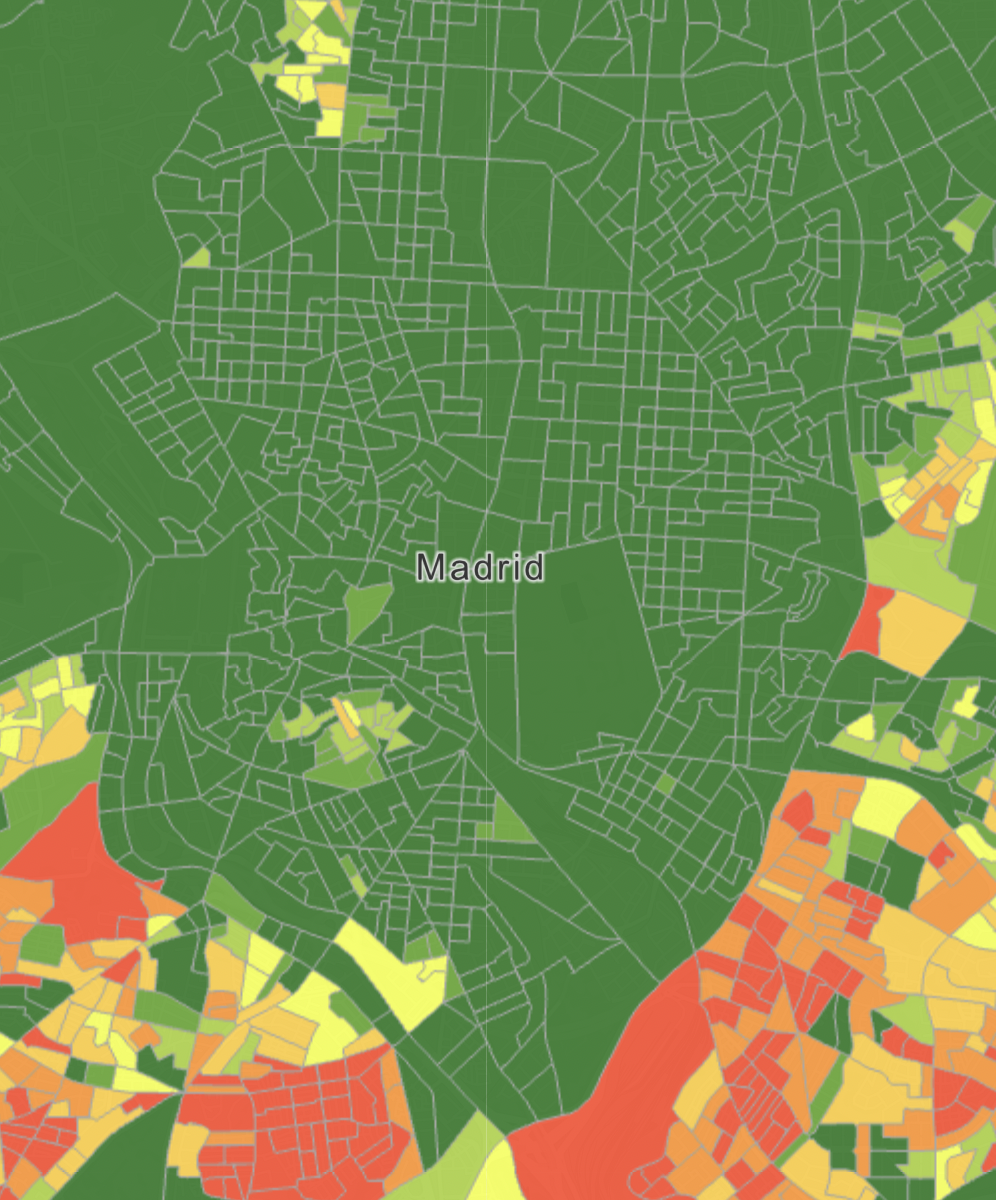